<a href="https://colab.research.google.com/github/nanhaishun/eat_tensorflow2_in_30_days/blob/practice/1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/nanhaishun/eat_tensorflow2_in_30_days.git

Cloning into 'eat_tensorflow2_in_30_days'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 14620 (delta 94), reused 193 (delta 86), pack-reused 14378
Receiving objects: 100% (14620/14620), 60.02 MiB | 26.32 MiB/s, done.
Resolving deltas: 100% (13201/13201), done.
Checking out files: 100% (12530/12530), done.


1-1,结构化数据建模流程范例

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers

In [ ]:
dftrain_raw = pd.read_csv('/content/eat_tensorflow2_in_30_days/data/titanic/train.csv')
dftest_raw = pd.read_csv('/content/eat_tensorflow2_in_30_days/data/titanic/test.csv')
dftrain_raw.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5,C30,S






字段说明：

Survived:0代表死亡，1代表存活【y标签】
Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
Name:乘客姓名 【舍去】
Sex:乘客性别 【转换成bool特征】
Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
Parch:乘客父母/孩子的个数(整数值)【数值特征】
Ticket:票号(字符串)【舍去】
Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】

利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）。

label分布情况

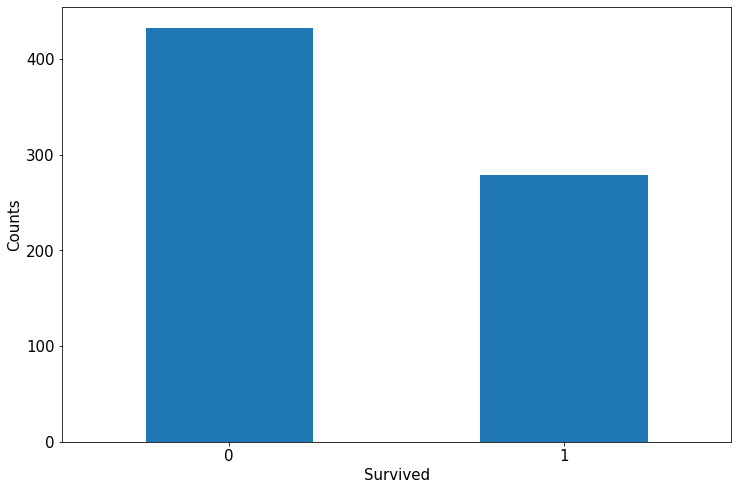

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Survived',fontsize = 15)
plt.show()

年龄分布情况

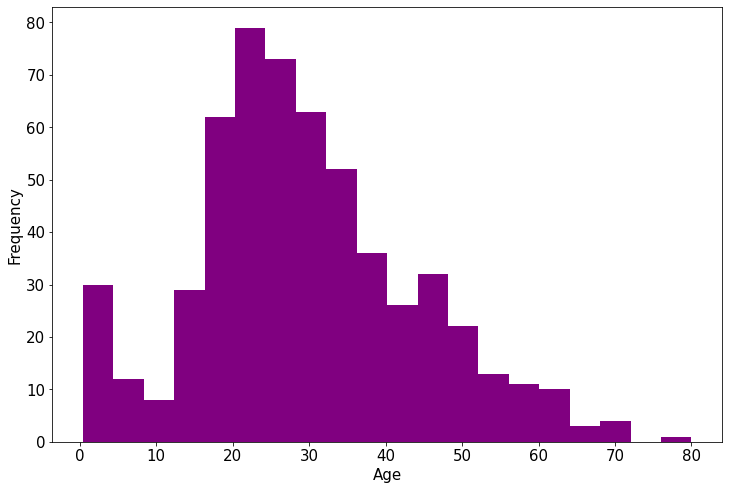

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 20,color= 'purple',
                    figsize = (12,8),fontsize=15)
 
ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

下面为正式的数据预处理

In [ ]:
def preprocessing(dfdata):
 
    dfresult= pd.DataFrame()
 
    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)
 
    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)
 
    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')
 
    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']
 
    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')
 
    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)
 
    return(dfresult)

In [ ]:
x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values
 
x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values
 
print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

x_train.shape = (712, 15)
x_test.shape = (179, 15)


In [ ]:
x_train.columns

Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'female', 'male', 'Age', 'Age_null',
       'SibSp', 'Parch', 'Fare', 'Cabin_null', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Embarked_nan'],
      dtype='object')

二，定义模型
使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用最简单的Sequential，按层顺序模型。

In [ ]:
tf.keras.backend.clear_session()
#定义在：tensorflow/python/keras/backend.py。
#销毁当前的TF图并创建一个新图。
#有助于避免旧模型/图层混乱。
model = models.Sequential()
model.add(layers.Dense(20,activation = 'relu',input_shape=(15,)))
model.add(layers.Dense(10,activation = 'relu' ))
model.add(layers.Dense(1,activation = 'sigmoid' ))
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


三，训练模型
训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

In [ ]:
# 二分类问题选择二元交叉熵损失函数
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['AUC'])
history = model.fit(x_train,y_train,
                    batch_size= 64,
                    epochs= 30,
                    validation_split=0.2 #分割一部分训练数据用于验证
                   )

Epoch 1/30
9/9 [==============================] - 1s 51ms/step - loss: 1.7242 - auc: 0.3650 - val_loss: 1.5072 - val_auc: 0.4060
Epoch 2/30
9/9 [==============================] - 0s 7ms/step - loss: 1.3616 - auc: 0.3961 - val_loss: 1.4265 - val_auc: 0.4285
Epoch 3/30
9/9 [==============================] - 0s 7ms/step - loss: 1.2509 - auc: 0.4067 - val_loss: 1.3080 - val_auc: 0.4506
Epoch 4/30
9/9 [==============================] - 0s 7ms/step - loss: 1.0153 - auc: 0.4633 - val_loss: 1.1534 - val_auc: 0.4810
Epoch 5/30
9/9 [==============================] - 0s 7ms/step - loss: 0.9106 - auc: 0.5096 - val_loss: 0.9927 - val_auc: 0.5184
Epoch 6/30
9/9 [==============================] - 0s 7ms/step - loss: 0.8071 - auc: 0.5269 - val_loss: 0.8529 - val_auc: 0.5320
Epoch 7/30
9/9 [==============================] - 0s 7ms/step - loss: 0.7202 - auc: 0.5637 - val_loss: 0.7603 - val_auc: 0.5616
Epoch 8/30
9/9 [==============================] - 0s 7ms/step - loss: 0.6534 - auc: 0.6704 - val_loss: 

四，评估模型
我们首先评估一下模型在训练集和验证集上的效果。

In [ ]:
history.history["AUC"]

KeyError: ignored

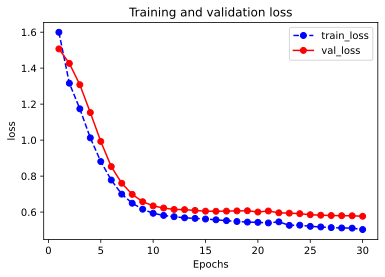

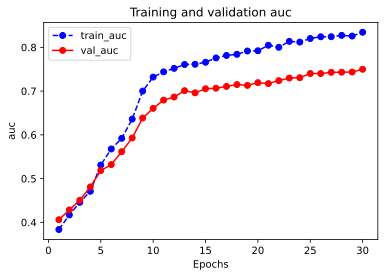

In [44]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
 
import matplotlib.pyplot as plt
 
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history,"loss")
plot_metric(history,"auc")

In [45]:
model.evaluate(x = x_test,y = y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.5118 - auc: 0.8177


[0.5117853879928589, 0.8177340030670166]

5. Model Application

In [46]:
#Predict the possiblities
model.predict(x_test[0:10])
#model(tf.constant(x_test[0:10].values,dtype = tf.float32)) #Identical way

array([[0.23883665],
       [0.39291438],
       [0.38781342],
       [0.7926644 ],
       [0.45358357],
       [0.41402584],
       [0.15086079],
       [0.638118  ],
       [0.43697536],
       [0.17711905]], dtype=float32)

In [47]:
#Predict the classes
model.predict_classes(x_test[0:10])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0]], dtype=int32)


6. Model Saving
The trained model could be saved through either the way of Keras or the way of original TensorFlow. The former only allows using Python to retrieve the model, while the latter allows cross-platform deployment.

The latter way is recommended to save the model.

(1) Model Saving with Keras

In [49]:
# Saving model structure and parameters

model.save('/content/keras_model.h5')  

del model  #Deleting current model

# Identical to the previous one
model = models.load_model('/content/keras_model.h5')
model.evaluate(x_test,y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.5118 - auc: 0.8177


[0.5117853879928589, 0.8177340030670166]

In [50]:
# Saving the model structure
json_str = model.to_json()

# Retrieving the model structure
model_json = models.model_from_json(json_str)

In [51]:
# Saving the weights of the model
model.save_weights('/content/keras_model_weight.h5')

# Retrieving the model structure
model_json = models.model_from_json(json_str)
model_json.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC']
    )

# Load the weights
model_json.load_weights('/content/keras_model_weight.h5')
model_json.evaluate(x_test,y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.5223 - auc: 0.8177


[0.5117853879928589, 0.8177340030670166]

(2) Model Saving with Original Way of TensorFlow

In [53]:
# Saving the weights, this way only save the tensors of the weights
model.save_weights('/content/tf_model_weights.ckpt',save_format = "tf")

In [54]:
# Saving model structure and parameters to a file, so the model allows cross-platform deployment

model.save('/content/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('/content/tf_model_savedmodel')
model_loaded.evaluate(x_test,y_test)

INFO:tensorflow:Assets written to: /content/tf_model_savedmodel/assets
export saved model.
6/6 [==============================] - 0s 2ms/step - loss: 0.5118 - auc: 0.8177


[0.5117853879928589, 0.8177340030670166]